# Setup 

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5dd58c32-cfaf-4635-9599-5d616a224709;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 433ms :: artifacts dl 41ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/30 23:56:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


In [4]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()
print(bucket)

# Create or retrieve a Spark session
spark = SparkSession.builder.appName("ReadS3Parquet").getOrCreate()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker-us-east-1-433974840707
23/11/30 23:56:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [23]:
import pyspark.sql.functions as F
from pyspark.sql.functions import date_format
from pyspark.sql.functions import avg
from pyspark.sql.functions import to_date
from pyspark.sql.functions import date_format
from pyspark.sql.functions import count

# Data

In [79]:
# S3 directory path
s3_directory = f"s3a://sagemaker-us-east-1-433974840707/project/nlp_cleaned_submissions/"

# Read all the Parquet files in the directory into a DataFrame
df_submissions = spark.read.parquet(s3_directory)

In [80]:
df_submissions.count()

599908

In [81]:
df_submissions.columns

['author',
 'title',
 'selftext',
 'subreddit',
 'score',
 'num_comments',
 'permalink',
 'created_utc',
 'url',
 'domain',
 'is_video',
 'is_self',
 'is_reddit_media_domain',
 'spoiler',
 'over_18',
 'stickied',
 'thumbnail',
 'media',
 'secure_media',
 'gilded',
 'archived',
 'distinguished',
 'cleaned_body',
 'cleaned_title']

In [82]:
df_submissions.printSchema()

root
 |-- author: string (nullable = true)
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- num_comments: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- created_utc: date (nullable = true)
 |-- url: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_reddit_media_domain: boolean (nullable = true)
 |-- spoiler: boolean (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- media: string (nullable = true)
 |-- secure_media: string (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- cleaned_body: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cl

In [83]:
# Keep relevant columns for the regression

from pyspark.sql.functions import length
from pyspark.sql.types import IntegerType

df = df_submissions.select('title' , 'subreddit' , 'score' , 'num_comments' , 'is_video' , 'spoiler' , 'over_18', 'created_utc', 'gilded')

df = df.withColumn('title_length', length(df['title'])) \
        .withColumn('year', F.year('created_utc')) \
        .withColumn('month', F.month('created_utc')) \
        .withColumn ('day', F.dayofmonth("created_utc")) \
        .withColumn('is_video', F.col('is_video').cast("string")) \
        .withColumn('spoiler', F.col('spoiler').cast("string")) \
        .withColumn('over_18', F.col('over_18').cast("string")) \
        .withColumn('num_comments', F.col('num_comments').cast(IntegerType()))

df = df.drop('title', 'created_utc')

df = df.dropna()

print("Number of records after dropping NAs: ", df.count())

df.show()

Number of records after dropping NAs:  599908
+---------+-----+------------+--------+-------+-------+------+------------+----+-----+---+
|subreddit|score|num_comments|is_video|spoiler|over_18|gilded|title_length|year|month|day|
+---------+-----+------------+--------+-------+-------+------+------------+----+-----+---+
|socialism|    6|           3|   false|  false|  false|     0|          48|2021|    7| 29|
|socialism|   11|           0|   false|  false|  false|     0|          76|2022|    4| 15|
|Economics|    1|           1|   false|  false|  false|     0|           7|2021|    2|  3|
|  Liberal|   17|           2|   false|  false|  false|     0|         103|2021|    6| 22|
|socialism| 1761|          43|   false|  false|  false|     0|         210|2021|    3| 25|
|socialism|  135|           5|   false|  false|  false|     0|          20|2021|    2|  4|
|socialism|    2|           1|   false|  false|  false|     0|          67|2022|   11| 27|
|socialism|  500|           0|   false|  fal

## Percentile Table of `score` and Value Counts of `is_video`, `spoiler`, `over_18`

In [84]:
# score

percentile_columns = ["score"]

# Specify the percentiles
percentiles = [0.01, 0.25, 0.5, 0.75, 0.99]

# Calculate percentiles and create a summary DataFrame
percentile_data = []

percentiles_values = df.approxQuantile("score", percentiles, relativeError=0.01)
percentile_data.append((column, *percentiles_values))

percentile_df = spark.createDataFrame(percentile_data, ["Column", "1%", "25%", "50%", "75%", "99%"])

# Display the percentile DataFrame
percentile_df.show()

+------+---+---+---+----+--------+
|Column| 1%|25%|50%| 75%|     99%|
+------+---+---+---+----+--------+
| score|0.0|1.0|1.0|29.0|110685.0|
+------+---+---+---+----+--------+



In [85]:
percentile_df = percentile_df.toPandas()
percentile_df.to_csv("../../data/csv/score_percentile.csv")

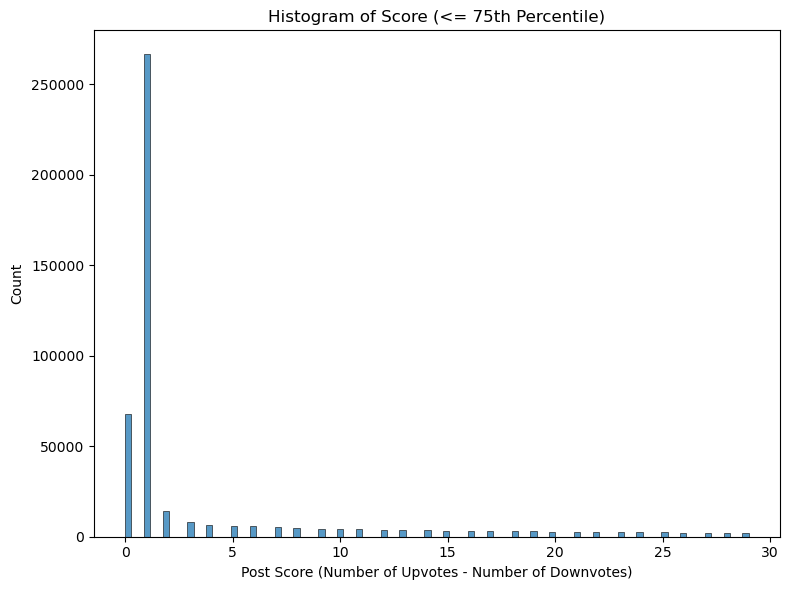

In [144]:
# Histogram up until 75th percentile

import seaborn as sns
import matplotlib.pyplot as plt

#df_score_pd = df.filter(F.col('score') <= 29).select("score").toPandas()
plt.figure(figsize=(8, 6))
sns.histplot(df_score_pd['score'], kde=False, bins=100)

# Display the histogram
plt.title('Histogram of Score (<= 75th Percentile)')
plt.xlabel('Post Score (Number of Upvotes - Number of Downvotes)')
plt.ylabel('Count', labelpad=5)
plt.savefig("../../data/plots/score_histogram_75perc.png")
plt.savefig("../../website-source/score_histogram_75perc.png")
plt.tight_layout()
plt.show()

In [87]:
video_value_count = df.groupby('is_video').count()
video_value_count.show()

+--------+------+
|is_video| count|
+--------+------+
|   false|596876|
|    true|  3032|
+--------+------+



In [88]:
video_value_count = video_value_count.toPandas()
video_value_count.to_csv("../../data/csv/video_val_count.csv")

In [89]:
spoiler_value_count = df.groupby('spoiler').count()
spoiler_value_count.show()

+-------+------+
|spoiler| count|
+-------+------+
|  false|598852|
|   true|  1056|
+-------+------+



In [90]:
spoiler_value_count = spoiler_value_count.toPandas()
spoiler_value_count.to_csv("../../data/csv/spoiler_val_count.csv")

In [91]:
over_18_value_count = df.groupby('over_18').count()
over_18_value_count.show()

+-------+------+
|over_18| count|
+-------+------+
|  false|595936|
|   true|  3972|
+-------+------+



In [92]:
over_18_value_count = over_18_value_count.toPandas()
over_18_value_count.to_csv("../../data/csv/18_val_count.csv")

### ML

## Creating data processing pipeline

In [93]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

subreddit_indexer = StringIndexer(inputCol="subreddit", outputCol="subreddit_index")
video_indexer = StringIndexer(inputCol="is_video", outputCol="is_video_index")
spoiler_indexer = StringIndexer(inputCol="spoiler", outputCol="spoiler_index")
over_18_indexer = StringIndexer(inputCol="over_18", outputCol="over_18_index")
subreddit_encoder = OneHotEncoder(inputCol="subreddit_index", outputCol="subreddit_vec")

pipeline = Pipeline(stages=[subreddit_indexer, video_indexer, spoiler_indexer, over_18_indexer, subreddit_encoder])

df_encoded = pipeline.fit(df).transform(df)

# Show the result
df_encoded.show()

+---------+-----+------------+--------+-------+-------+------+------------+----+-----+---+---------------+--------------+-------------+-------------+-------------+
|subreddit|score|num_comments|is_video|spoiler|over_18|gilded|title_length|year|month|day|subreddit_index|is_video_index|spoiler_index|over_18_index|subreddit_vec|
+---------+-----+------------+--------+-------+-------+------+------------+----+-----+---+---------------+--------------+-------------+-------------+-------------+
|socialism|    6|           3|   false|  false|  false|     0|          48|2021|    7| 29|            4.0|           0.0|          0.0|          0.0|(8,[4],[1.0])|
|socialism|   11|           0|   false|  false|  false|     0|          76|2022|    4| 15|            4.0|           0.0|          0.0|          0.0|(8,[4],[1.0])|
|Economics|    1|           1|   false|  false|  false|     0|           7|2021|    2|  3|            3.0|           0.0|          0.0|          0.0|(8,[3],[1.0])|
|  Liberal|   17

### Linear Regression

In [146]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Combine all features into a single vector
assembler = VectorAssembler(
    inputCols=["over_18_index", "spoiler_index", "is_video_index", "title_length", "subreddit_vec", "year", "month", "day", 'gilded', 'num_comments'],
    outputCol="assembled_features")

# Normalize the features
scaler = StandardScaler(inputCol="assembled_features", outputCol="features", withStd=True, withMean=True)

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="score")

# Define the Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Split the data into training and testing sets (80-20 split)
train_data, test_data = df_encoded.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(test_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared of test data = %g" % r2)
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE of test data = %g" % rmse)

23/12/01 02:39:44 WARN Instrumentation: [462af750] regParam is zero, which might cause numerical instability and overfitting.


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


R-squared of test data = 0.42904


RMSE of test data = 402.07


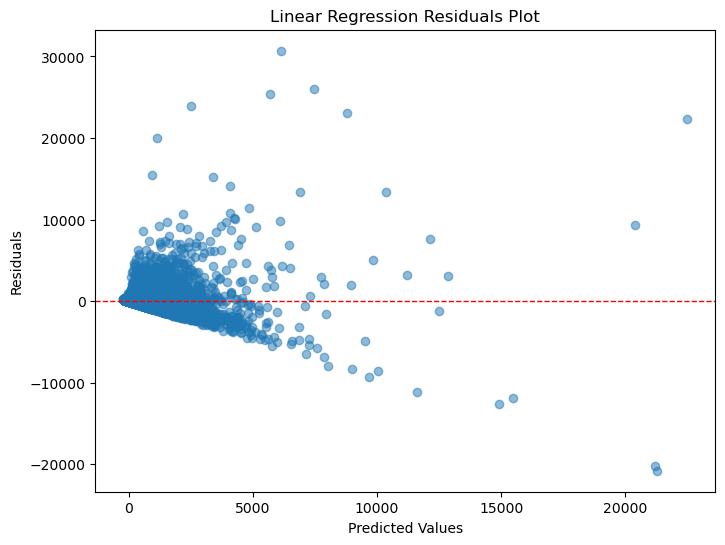

In [148]:
residuals = predictions.select("score", "prediction").toPandas()
residuals['residual'] = residuals['score'] - residuals['prediction']

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(residuals['prediction'], residuals['residual'], alpha=0.5)
plt.title('Linear Regression Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
plt.savefig("../../data/plots/residuals_lr.png")
plt.savefig("../../website-source/residuals_lr.png")
plt.show()

### Random Forest

In [149]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Combine all features into a single vector
assembler = VectorAssembler(
    inputCols=["over_18_index", "spoiler_index", "is_video_index", "title_length", "subreddit_vec", "year", "month", "day", 'gilded', 'num_comments'],
    outputCol="assembled_features")

# Normalize the features
scaler = StandardScaler(inputCol="assembled_features", outputCol="features", withStd=True, withMean=True)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="score", numTrees=100)

# Define the Pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Split the data into training and testing sets (80-20 split)
train_data, test_data = df_encoded.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(test_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE of test data = %g" % rmse)

R-squared on test data = 0.385552


RMSE of test data = 417.101


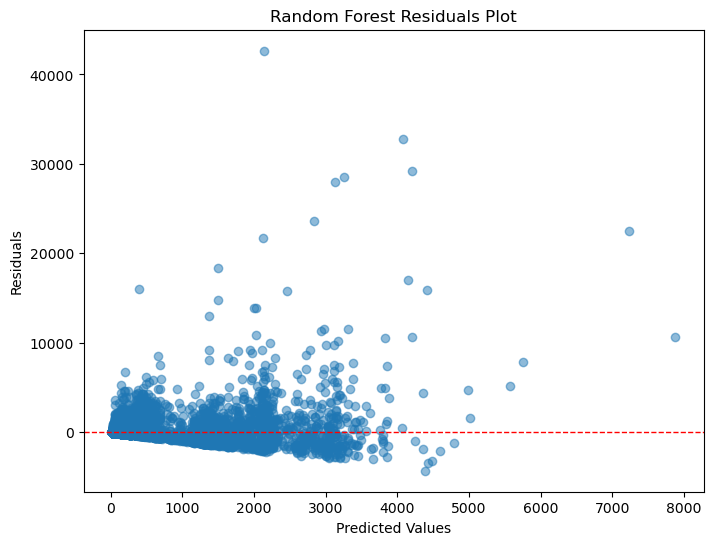

In [150]:
residuals = predictions.select("score", "prediction").toPandas()
residuals['residual'] = residuals['score'] - residuals['prediction']

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(residuals['prediction'], residuals['residual'], alpha=0.5)
plt.title('Random Forest Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
plt.savefig("../../data/plots/residuals_rf.png")
plt.savefig("../../website-source/residuals_rf.png")
plt.show()

In [109]:
# Access the RandomForest model from the pipeline stages
rf_model = model.stages[-1]

# Get feature importance values
feature_importance = rf_model.featureImportances

# Extract feature names
feature_names = ["over_18_index", "spoiler_index", "is_video_index", "title_length", "subreddit_vec", "year", "month", "day", 'gilded', 'num_comments']

# Create a dictionary to pair feature names with their importance values
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort features based on importance scores (descending order)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display sorted feature importance
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

day: 0.041162724763995
title_length: 0.02911211944794473
subreddit_vec: 0.018456931691532435
gilded: 0.01006361390871375
year: 0.007720383501115649
over_18_index: 0.006963511628588753
month: 0.0066206518431535955
is_video_index: 0.004671689038955979
num_comments: 0.0007592638545857677
spoiler_index: 1.066149091657243e-06


In [122]:
import pandas as pd

df = pd.DataFrame.from_dict(feature_importance_dict, orient='index', columns=['importance'])

# Reset the index and move it to columns
df_reset = df.reset_index()

# Rename the columns as needed
df_reset.columns = ['feature', 'importance']

# Sort the DataFrame by importance in descending order
df_reset = df_reset.sort_values(by='importance', ascending=False)

# Display the sorted DataFrame
print(df_reset)

          feature  importance
7             day    0.041163
3    title_length    0.029112
4   subreddit_vec    0.018457
8          gilded    0.010064
5            year    0.007720
0   over_18_index    0.006964
6           month    0.006621
2  is_video_index    0.004672
9    num_comments    0.000759
1   spoiler_index    0.000001


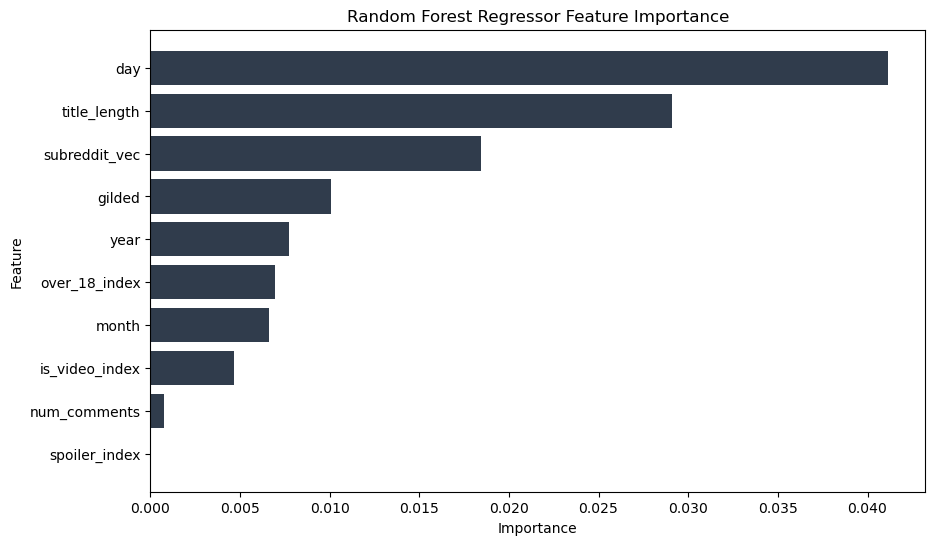

In [128]:
# Feature Importance plot

df_reset = pd.DataFrame({
    'feature': ['day', 'title_length', 'subreddit_vec', 'gilded', 'year', 'over_18_index', 'month', 'is_video_index', 'num_comments', 'spoiler_index'],
    'importance': [0.041163, 0.029112, 0.018457, 0.010064, 0.007720, 0.006964, 0.006621, 0.004672, 0.000759, 0.000001]
})

# Sort the DataFrame by importance in descending order
df_reset = df_reset.sort_values(by='importance', ascending=True)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(df_reset['feature'], df_reset['importance'], color='#303c4c')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Regressor Feature Importance')
plt.savefig("../../data/plots/rf_feature_imp.png")
plt.savefig("../../website-source/rf_feature_imp.png") 
plt.show()